In [1]:
# Import libraries
from matplotlib import rc
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings

In [2]:
# Warning messages options
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Pandas options for better showing dataframes
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)

In [4]:
# Setting size for plots
fig_dim = (12, 8)

In [5]:
# Make overarching aesthetic settings for the plots
sns.set_palette("Spectral_r")

In [6]:
# Aesthetic settings for the plots
sns.set_theme(style = "white", font_scale = 1.25)
classes = "tab20"
prisec = "PRGn_r"
others = "RdYlGn"

In [7]:
# Define X axis labels
xlabs = ["Gene Expression", "RNA-Seq", "Other SRA"]

In [8]:
# Additional functions
def in_list(pot_vec, ref_vec):
    bools = []
    for i in pot_vec:
        if(type(i) == str):
            if(i in ref_vec):
                bools.append(True)
            else:
                bools.append(False)
        else:
            bools.append(False)
    return bools

In [9]:
# Read datasets
metadata_df = pd.read_csv('../data/metadata.csv')
countries_df = pd.read_csv('../data/countries.csv')
gdp_df = pd.read_csv('../data/gdp.csv')
papers_df = pd.read_csv('../data/papers.csv')

/tmp/ipykernel_1285568/3567920919.py:2: DtypeWarning: Columns (0,5,6,12,16,17,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv('../data/metadata.csv')


In [10]:
# Count unique values for publications ids and accessions
metadata_df[['pmc_ID', 'accession']].nunique()

pmc_ID       213213
accession    277762
dtype: int64

In [11]:
# Count unqiue journal names
metadata_df.journal.value_counts()

PLoS One                     151039
Sci Rep                      136757
Int J Mol Sci                 63518
Cureus                        53554
Nat Commun                    44143
                              ...  
Int J Sport Exerc Psychol         1
Interpret Transl Train            1
Youth (Basel)                     1
J Comput Math Data Sci            1
Artif Intell Chem                 1
Name: journal, Length: 10870, dtype: int64

In [12]:
total_papers = papers_df[['pmc_ID']].drop_duplicates()
print("Total papers using omics data : ", str(len(total_papers)))

Total papers using omics data :  213213


In [13]:
# Count percent for each repository
rc = Counter(papers_df['class'])
repoCounts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
repoCounts = repoCounts.dropna()
repoCounts.columns = ['repository', 'count']
repoCounts['percent'] = repoCounts['count'] / repoCounts['count'].sum()
repoCounts = repoCounts.sort_values(by = "percent", ascending = False)

repoCounts_T = repoCounts.T

cols = repoCounts_T.iloc[0, :]

repoCounts_T.columns = cols
repoCounts_T = repoCounts_T.iloc[2:,:]
repoCounts_T

repository,RNA-Seq,GEO_expr,SRA_other
percent,0.398383,0.322891,0.278726


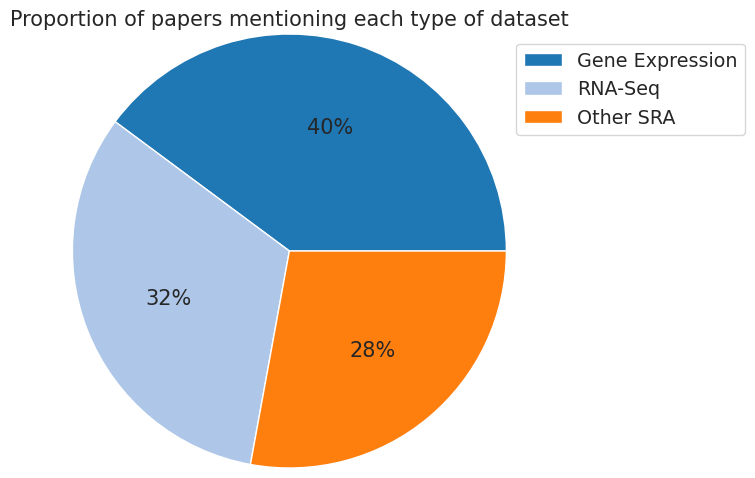

In [14]:
# Visualize breakdown of repositories mentioned by papers
sns.set_palette(classes)
fig, ax = plt.subplots(figsize = (7, 7))
ax.pie(repoCounts["percent"], autopct='%1.f%%')
plt.ylim(0,1)
plt.legend(["Gene Expression", "RNA-Seq", "Other SRA", "Multiple"], bbox_to_anchor = [0.9, 1])
title = "Proportion of papers mentioning each type of dataset"
ax.set_title(title)
plt.savefig("../figures/(Figure 1)pctMentioningPie.png", dpi = 300, bbox_inches = "tight")

In [15]:
# How many papers reuse and generate
rc

Counter({'RNA-Seq': 78613, 'SRA_other': 55001, 'GEO_expr': 63716, nan: 15883})

In [16]:
# How many papers reuse, generate and both?
rc = {'class':['generating', 'reusing', 'both']}

for c in ["RNA-Seq", "GEO_expr", "SRA_other"]:
    rec = Counter(papers_df.loc[papers_df['class'] == c, :]['reuse_role'])
    reCo = pd.DataFrame.from_dict(rec, orient = 'index').reset_index()
    reCo.columns = ['reuse_role', 'count']
    reCo['percent'] = reCo['count'] / reCo['count'].sum()
    rc[c] = reCo['percent']
    
reuseCounts = pd.DataFrame(rc).T
reuseCounts.columns = reuseCounts.iloc[0,:]
reuseCounts = reuseCounts.iloc[1:,:]
reuseCounts = reuseCounts.sort_values(by = "reusing", ascending = False)
reuseCounts

class,generating,reusing,both
RNA-Seq,0.351647,0.638559,0.009795
SRA_other,0.701351,0.285322,0.013327
GEO_expr,0.724967,0.269289,0.005744


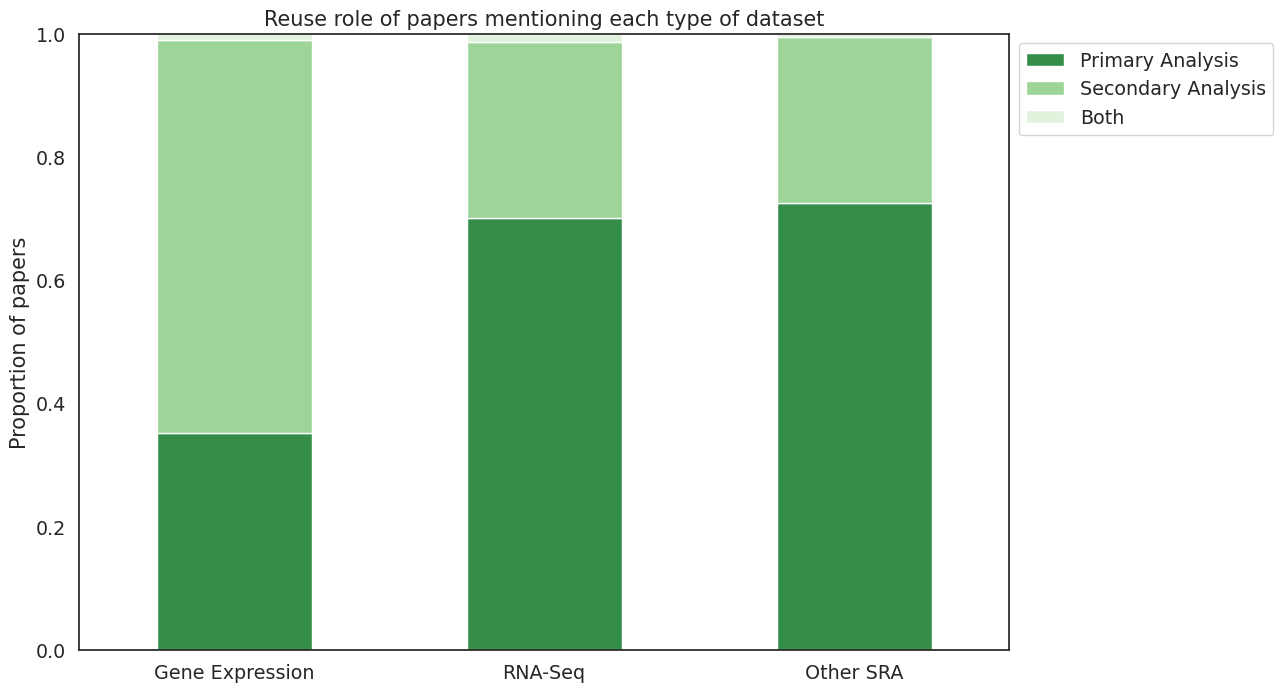

In [17]:
# Visualize reuse role of papers mentioning each type of dataset
sns.set_palette(prisec)
ax = reuseCounts.plot(kind = 'bar', stacked = True, figsize = fig_dim)
plt.ylim(0,1)
title = "Reuse role of papers mentioning each type of dataset"
ax.set_title(title)
plt.xticks(ticks = [0, 1, 2], labels = xlabs, rotation = 0)
plt.ylabel("Proportion of papers")
plt.legend(["Primary Analysis", "Secondary Analysis", "Both"], bbox_to_anchor = [1, 1])
plt.savefig("../figures/(Figure 2) reuseRoleRepos.png", dpi = 300, bbox_inches = "tight")

In [18]:
# Preprocess data for reuse and repository distribution across the years
repo_byDate = papers_df.groupby(['year', 'class'])['class'].count().to_frame(name = 'repo_count').reset_index()

In [19]:
dropme = repo_byDate[repo_byDate['year'] == 2025].index
repo_byDate.drop(dropme, inplace = True)

years = repo_byDate['year'].drop_duplicates().to_list()
years = [int(i) for i in years]

In [20]:
# NON-CUMULATIVE
z = {'year': repo_byDate['year'], 'repository': 'GEO', 'repo_count': 0}
z2 = {'year': repo_byDate['year'], 'repository': 'SRA', 'repo_count': 0}
z3 = {'year': repo_byDate['year'], 'repository': 'Multiple', 'repo_count': 0}

# Create DataFrames from the dictionaries
zerosGEO = pd.DataFrame(data=z)
zerosSRA = pd.DataFrame(data=z2)
zerosBoth = pd.DataFrame(data=z3)

# Concatenate the DataFrames with repo_byDate for each repository type
gexp_byDate = pd.concat([repo_byDate.loc[repo_byDate['class'] == "GEO_expr", :], zerosGEO], ignore_index=True).groupby(['year'], sort=False).sum().reset_index().sort_values(by='year')
rnaseq_byDate = pd.concat([repo_byDate.loc[repo_byDate['class'] == "RNA-Seq", :], zerosGEO], ignore_index=True).groupby(['year'], sort=False).sum().reset_index().sort_values(by='year')
sra_byDate = pd.concat([repo_byDate.loc[repo_byDate['class'] == "SRA_other", :], zerosSRA], ignore_index=True).groupby(['year'], sort=False).sum().reset_index().sort_values(by='year')
mult_byDate = pd.concat([repo_byDate.loc[repo_byDate['class'] == "Multiple", :], zerosBoth], ignore_index=True).groupby(['year'], sort=False).sum().reset_index().sort_values(by='year')

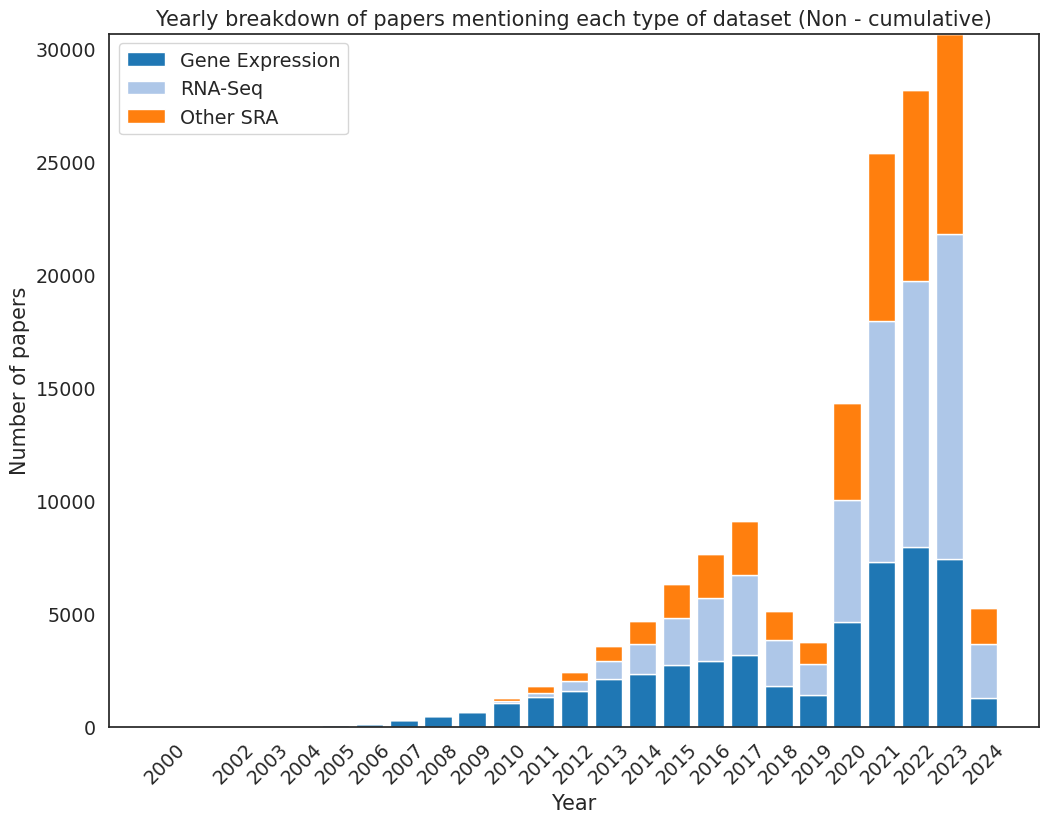

In [21]:
# NON-CUMULATIVE
sns.set_palette(classes)
fig, ax = plt.subplots(figsize = (12, 9))

plt.bar(years, gexp_byDate['repo_count'])
plt.bar(years, rnaseq_byDate['repo_count'], 
        bottom = gexp_byDate['repo_count'])
plt.bar(years, sra_byDate['repo_count'], 
        bottom = [i+j for i, j in zip(gexp_byDate['repo_count'], rnaseq_byDate['repo_count'])])
plt.bar(years, mult_byDate['repo_count'], 
        bottom = [i+j+k for i, j, k in zip(gexp_byDate['repo_count'], rnaseq_byDate['repo_count'], sra_byDate['repo_count'])])

plt.xticks(ticks = years, rotation = 45)
title = "Yearly breakdown of papers mentioning each type of dataset (Non - cumulative)"
plt.title(title)
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.legend(["Gene Expression", "RNA-Seq", "Other SRA"], loc = 'upper left')
# plt.savefig("../figures/repoTimeSer.png", dpi = 300, bbox_inches = "tight")
plt.show()

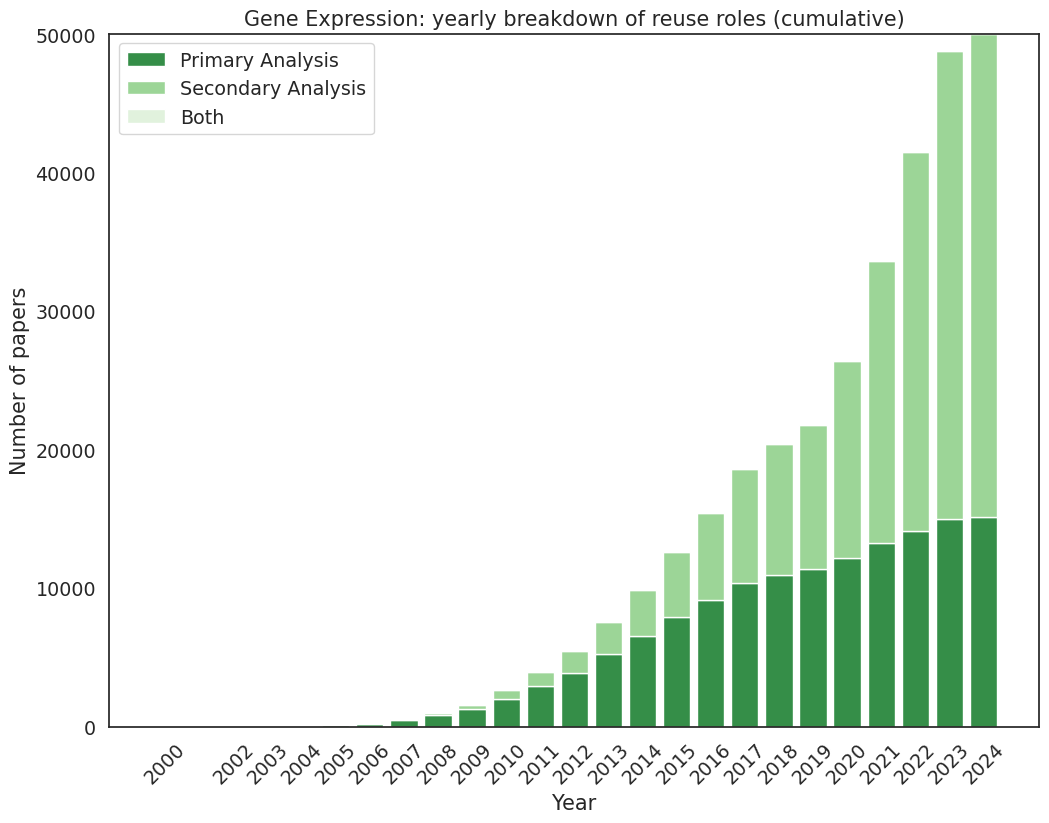

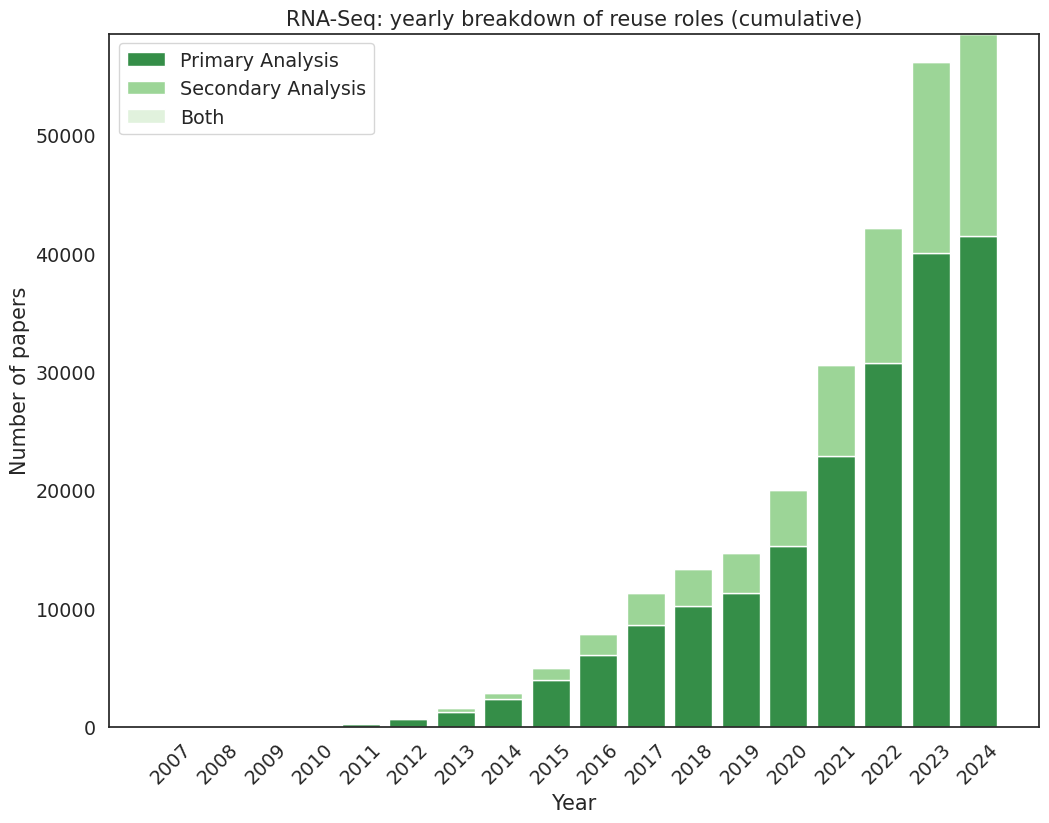

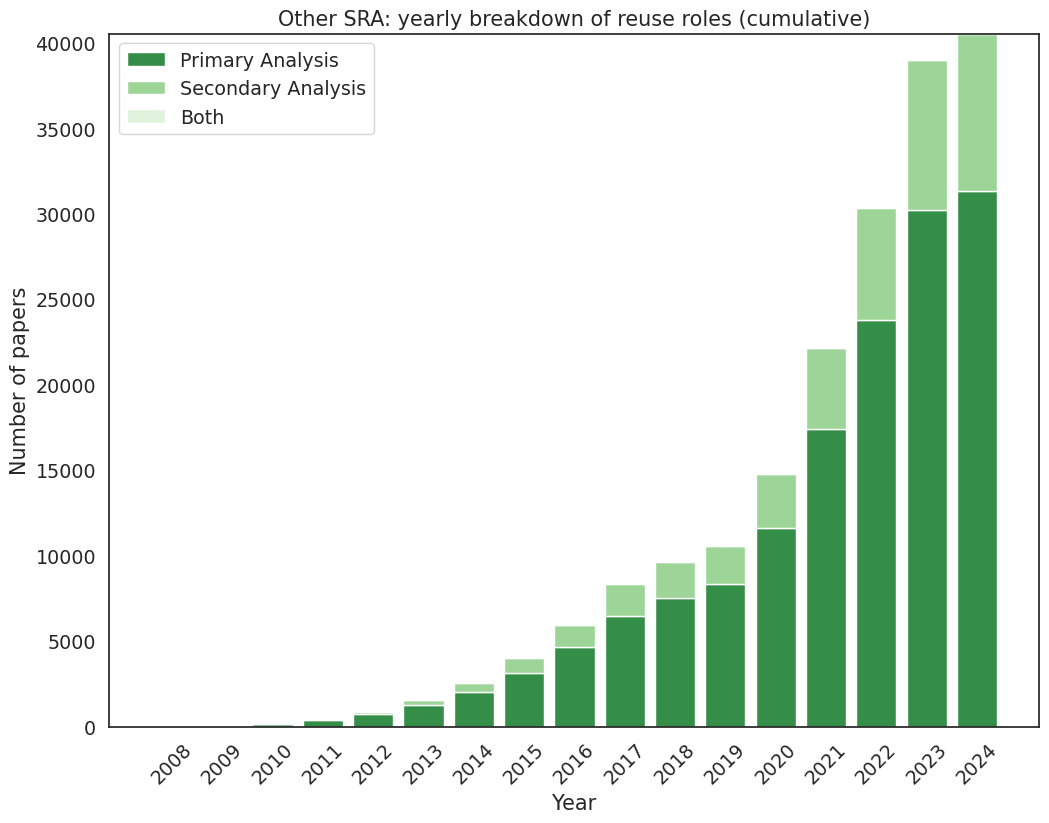

In [22]:
# CUMULATIVE

# Get reuse counts per date
# CUMULATIVE
reuse_byDateGEOexpr = papers_df.loc[papers_df['class'] == 'GEO_expr', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()
reuse_byDateRNAseq = papers_df.loc[papers_df['class'] == 'RNA-Seq', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()
reuse_byDateSRAother = papers_df.loc[papers_df['class'] == 'SRA_other', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()

timesthru = 0
sns.set_palette(prisec)
for reuse_byDate in [reuse_byDateGEOexpr, reuse_byDateRNAseq, reuse_byDateSRAother]:
    
    dropme = reuse_byDate[reuse_byDate['year'] == 2025].index
    reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}
    z3 = {'year':years, 'reuse_role':'Multiple', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)
    zerosBoth = pd.DataFrame(data = z3)

    # R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index().cumsum()
    # G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index().cumsum()
    # bothReuse_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'Multiple', :].append(zerosBoth).groupby(['year']).sum().reset_index().cumsum()

   # Concatenate the DataFrames with reuse_byDate for each reuse_role
    R_byDate = pd.concat([reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :], zerosG], ignore_index=True).groupby(['year']).sum().reset_index().cumsum().sort_values(by='year')
    G_byDate = pd.concat([reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :], zerosR], ignore_index=True).groupby(['year']).sum().reset_index().cumsum().sort_values(by='year')
    bothReuse_byDate = pd.concat([reuse_byDate.loc[reuse_byDate['reuse_role'] == 'Multiple', :], zerosBoth], ignore_index=True).groupby(['year']).sum().reset_index().cumsum().sort_values(by='year') 
        
    fig, ax = plt.subplots(figsize = (12, 9))

    plt.bar(years, G_byDate['reuse_count'])
    plt.bar(years, R_byDate['reuse_count'], 
            bottom = G_byDate['reuse_count'])
    plt.bar(years, bothReuse_byDate['reuse_count'], 
            bottom = [i+j for i, j in zip(G_byDate['reuse_count'], R_byDate['reuse_count'])])

    if timesthru == 0:
        cls = "Gene Expression"
    elif timesthru == 1:
        cls = "RNA-Seq"
    elif timesthru == 2:
        cls = "Other SRA"
    timesthru = timesthru + 1
        
    plt.xticks(ticks = years, rotation = 45)
    title = str(cls) + ": yearly breakdown of reuse roles (cumulative)"
    plt.title(title)
    plt.legend(["Primary Analysis", "Secondary Analysis", "Both"], loc = 'upper left')
    plt.xlabel("Year")
    plt.ylabel("Number of papers")
    filename = "../figures/(Figure 3) cumTimeSer_" + cls + ".png"
    plt.savefig(filename, dpi = 300, bbox_inches = "tight")
    plt.show()


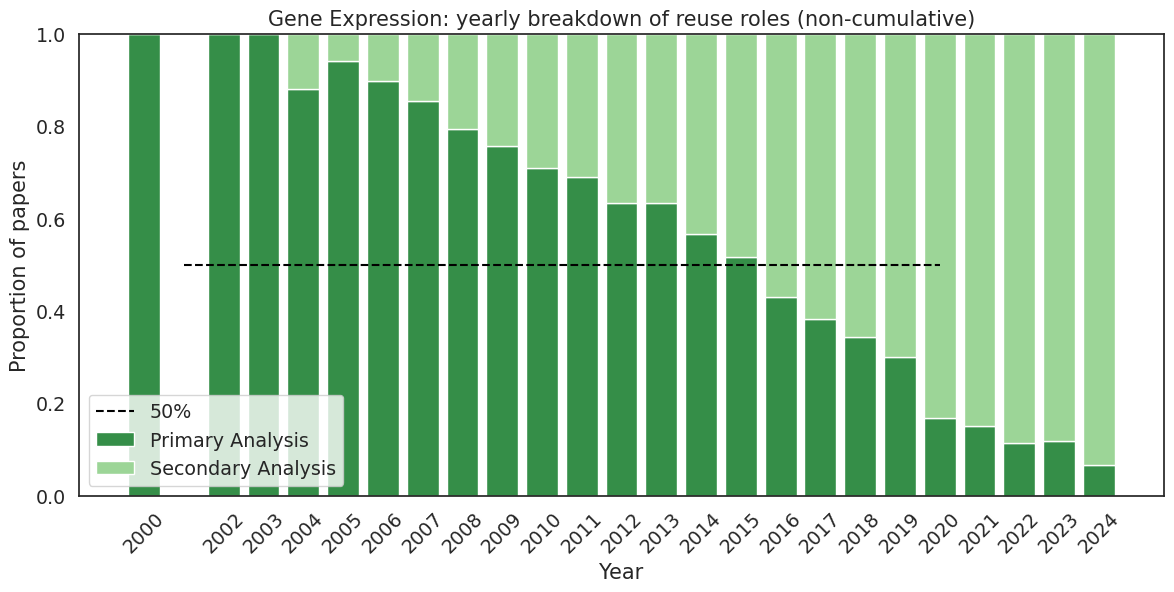

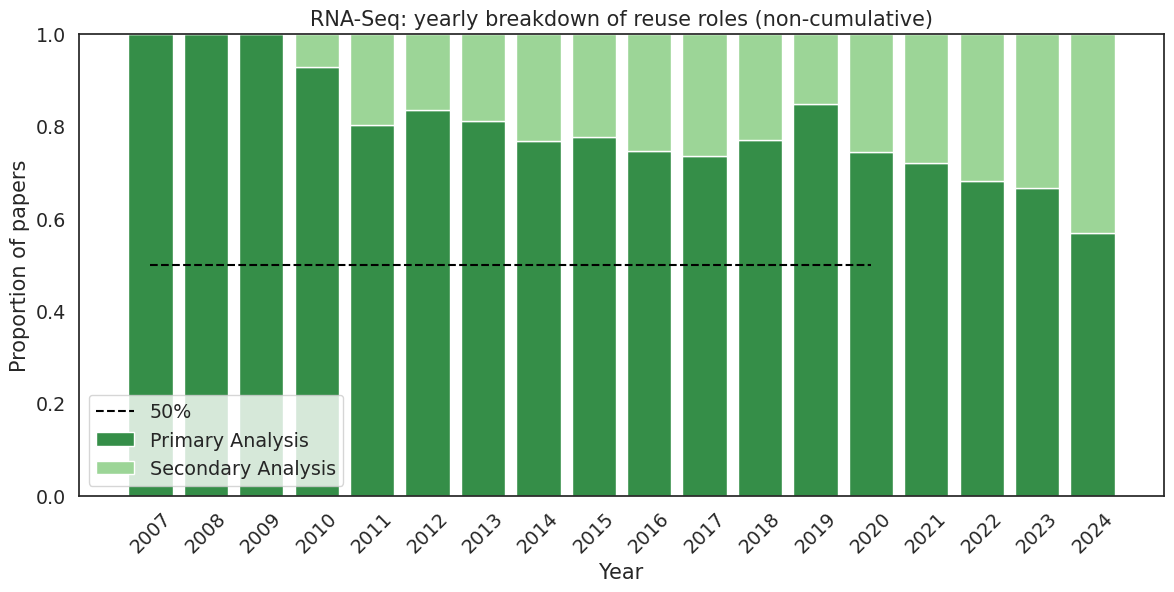

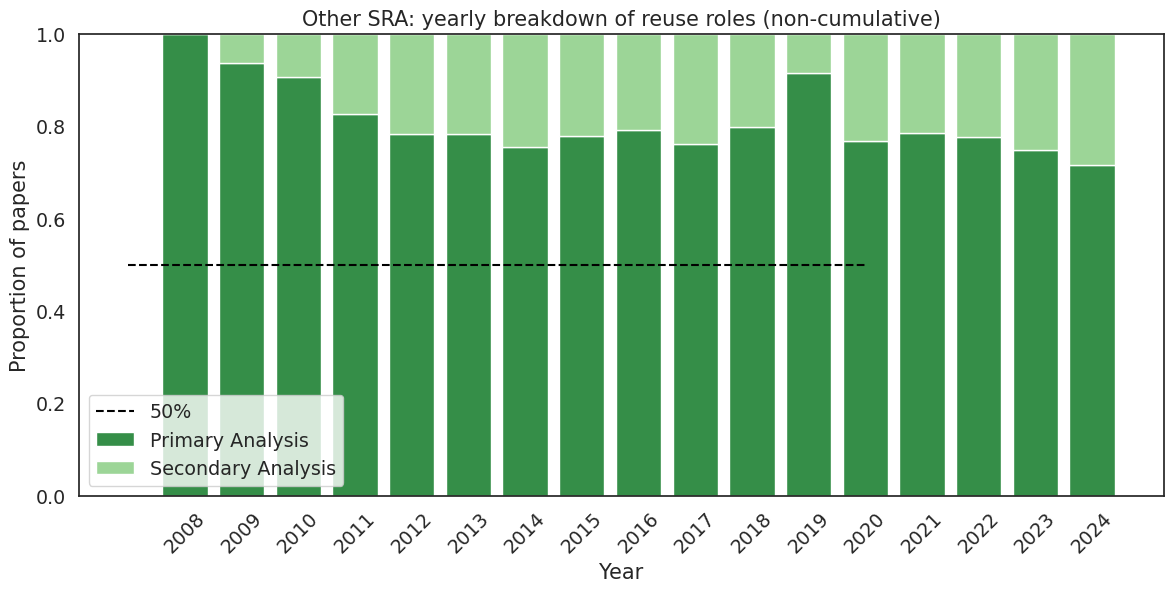

In [23]:
# NON-CUMULATIVE
timesthru = 0
# sns.set_palette(prisec)
for reuse_byDate in [reuse_byDateGEOexpr, reuse_byDateRNAseq, reuse_byDateSRAother]:
    
    # dropme = reuse_byDate[reuse_byDate['year'] == 2025].index
    # reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)

    # R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index()
    # G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index()

    R_byDate = pd.concat([reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :], zerosG]).groupby(['year']).sum().reset_index()
    G_byDate = pd.concat([reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :], zerosR]).groupby(['year']).sum().reset_index()

    
    fig, ax = plt.subplots(figsize = (14, 6))
    
    total_counts = G_byDate['reuse_count'] + R_byDate['reuse_count'] # + bothReuse_byDate['reuse_count']
    plt.bar(years, G_byDate['reuse_count'] / total_counts)
    plt.bar(years, R_byDate['reuse_count'] / total_counts, 
            bottom = G_byDate['reuse_count'] / total_counts)
    
    if timesthru == 0:
        cls = "Gene Expression"
        plt.plot([2001, 2020], [0.5, 0.5], '--', color = 'black')
    elif timesthru == 1:
        cls = "RNA-Seq"
        plt.plot([2007, 2020], [0.5, 0.5], '--', color = 'black')
    elif timesthru == 2:
        cls = "Other SRA"
        plt.plot([2007, 2020], [0.5, 0.5], '--', color = 'black')
    timesthru = timesthru + 1
    
    plt.rc('font', size = 18)
    plt.xticks(ticks = years, rotation = 45)
    title = str(cls) + ": yearly breakdown of reuse roles (non-cumulative)"
    plt.title(title)
    plt.legend(["50%", "Primary Analysis", "Secondary Analysis"], loc = 'lower left')
    plt.xlabel("Year")
    plt.ylabel("Proportion of papers")    
    filename = "../figures/(Figure 4) nonCumTimeSer_" + cls + ".png"
    plt.savefig(filename, dpi = 300, bbox_inches = "tight")
    plt.show()
        
plt.rc('font', size = 12)

In [24]:
# Preprocess for percentage of datasets what are used more than once
mm = metadata_df

In [25]:
accs = mm[['converted_accession', 'Date', 'repository', 'reuse_count', 'norm_reuse_count', 'time_public', 'class']].drop_duplicates()

In [26]:
# What percentage of datasets are used more than once (re-used at least once)?
accs['wasReused'] = accs['reuse_count'] * accs['time_public'] >= 1
accsPcts = accs.groupby('class', as_index = False).agg({'wasReused':'mean'})
accsPcts = accsPcts.rename(columns = {'wasReused':'pctReused'})

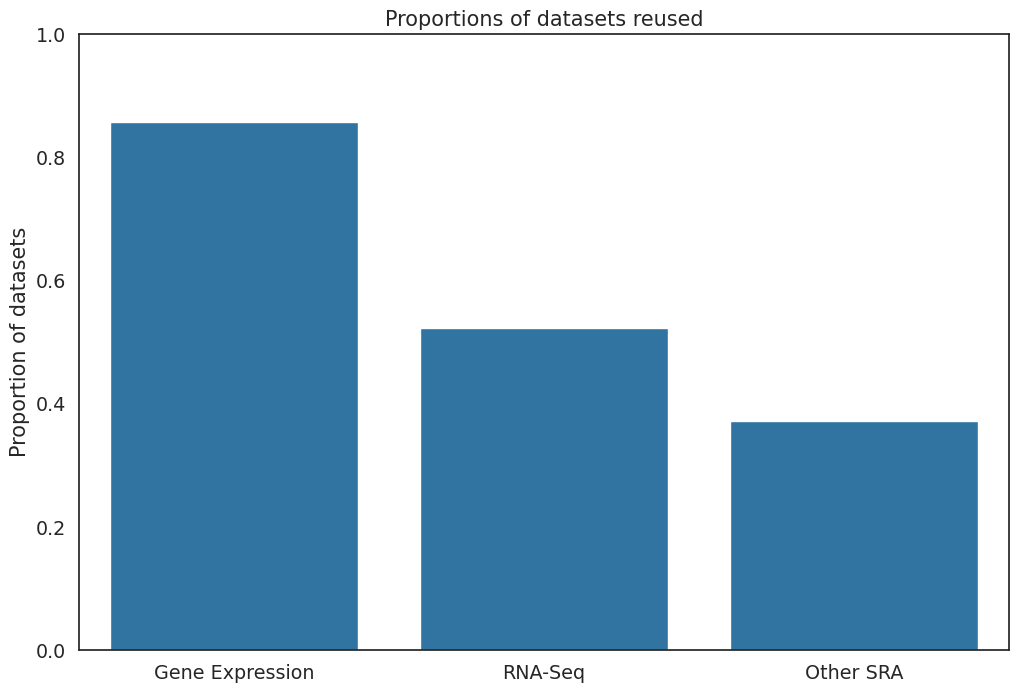

In [28]:
# Plot barplot showing percentage of datasets reused in GEO and SRA
sns.set_palette(classes)
fig, ax = plt.subplots(figsize=fig_dim)
sns.barplot(data = accsPcts, x = 'class', y = 'pctReused', ax = ax)
plt.ylim(0,1)
title = "Proportions of datasets reused"
ax.set_title(title)
plt.xticks(ticks = [0, 1, 2], labels = xlabs)
plt.xlabel("")
plt.ylabel("Proportion of datasets")
plt.savefig("../figures/(Figure 5) pctDataReused.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [29]:
# Reuse distribution of reused datasets
accs_filt = accs.loc[accs['reuse_count'] > 0, :]

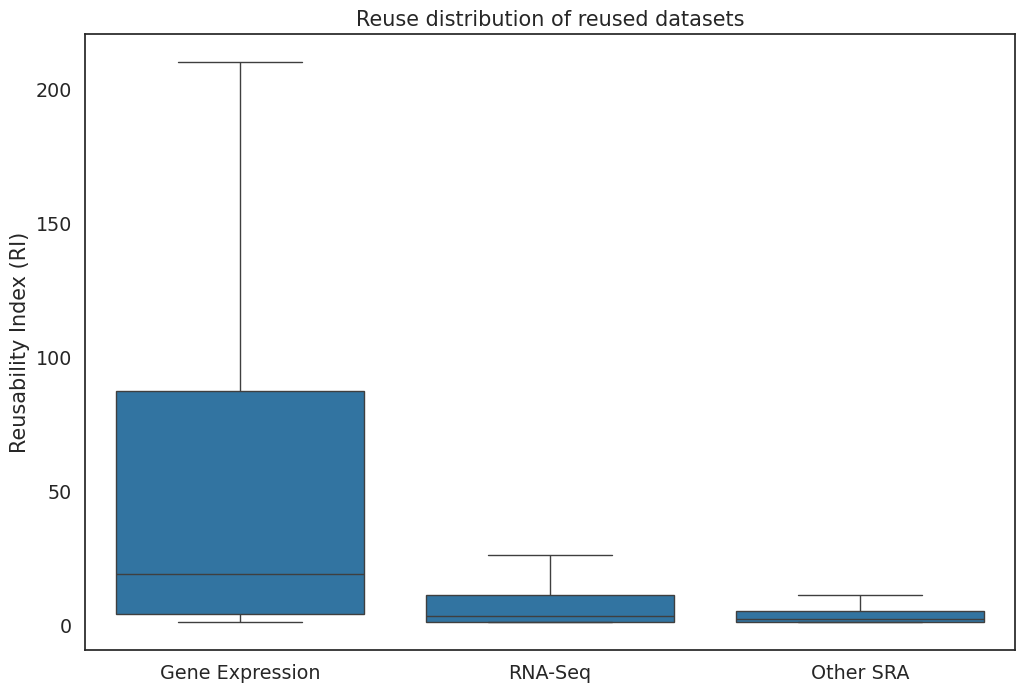

In [30]:
sns.set_palette(classes)
fig, ax = plt.subplots(figsize=fig_dim)
datasets_box = sns.boxplot(data = accs_filt, x = 'class', y = 'reuse_count', showfliers = False, ax = ax,
                          order = ["GEO_expr", "RNA-Seq", "SRA_other"])

title = "Reuse distribution of reused datasets"
ax.set_title(title)
plt.xticks(ticks = [0, 1, 2], labels = xlabs)
plt.xlabel("")
plt.ylabel("Reusability Index (RI)")
plt.savefig("../figures/(Figure 6) reuseDistRepos.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [32]:
import statistics

In [33]:
sraMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "SRA_other"]['reuse_count'])
gexpMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "GEO_expr"]['reuse_count'])
rnaseqMean = statistics.mean(accs_filt.loc[accs_filt['class'] == "RNA-Seq"]['reuse_count'])
print("SRA mean reuse count is " + str(sraMean))
print("RNA-Seq mean reuse count is " + str(rnaseqMean))
print("Gene expression mean reuse count is " + str(gexpMean))

sraMed = statistics.median(accs_filt.loc[accs_filt['class'] == "SRA_other"]['reuse_count'])
gexpMed = statistics.median(accs_filt.loc[accs_filt['class'] == "GEO_expr"]['reuse_count'])
rnaseqMed = statistics.median(accs_filt.loc[accs_filt['class'] == "RNA-Seq"]['reuse_count'])
print("SRA median reuse count is " + str(sraMed))
print("RNA-Seq median reuse count is " + str(rnaseqMed))
print("Gene expression median reuse count is " + str(gexpMed))

SRA mean reuse count is 6.702009524200501
RNA-Seq mean reuse count is 17.905854590054492
Gene expression mean reuse count is 119.6520543571618
SRA median reuse count is 2.0
RNA-Seq median reuse count is 3.0
Gene expression median reuse count is 19.0


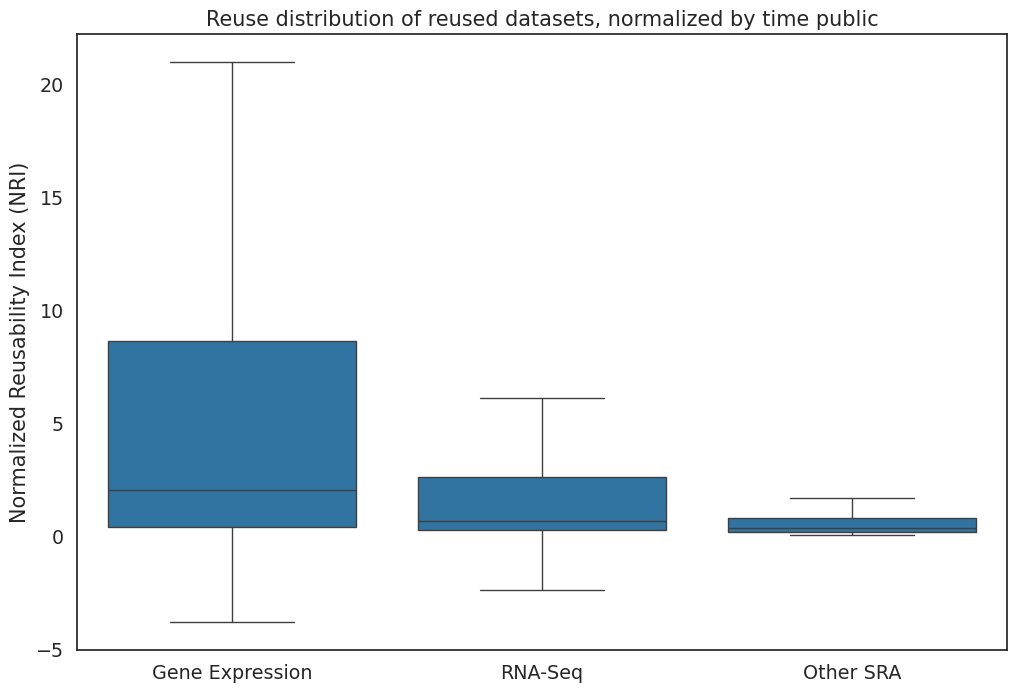

In [34]:
# Plot the distribution of reuse for each dataset, normalized by time public
sns.set_palette(classes)
fig, ax = plt.subplots(figsize=fig_dim)
datasets_box = sns.boxplot(data = accs_filt, x = 'class', y = 'norm_reuse_count', showfliers = False, ax = ax,
                          order = ["GEO_expr", "RNA-Seq", "SRA_other"])
title = "Reuse distribution of reused datasets, normalized by time public"
ax.set_title(title)
plt.xticks(ticks = [0, 1, 2], labels = xlabs)
plt.xlabel("")
plt.ylabel("Normalized Reusability Index (NRI)")
plt.savefig("../figures/(Figure 7) reuseDistRepos_norm.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [35]:
paps = papers_df
paps

,pmc_ID,repository,reuse_role,pmc_date,library_strategy,class,year
0,PMC10000039,GEO,R,2022-12-25,RNA-Seq,RNA-Seq,2022.0
1,PMC10000042,SRA,G,2023-02-16,WGA,SRA_other,2023.0
2,PMC10000051,GEO,R,2023-02-14,Expression_Array,GEO_expr,2023.0
3,PMC10000067,SRA,G,2023-03-01,RNA-Seq,RNA-Seq,2023.0
4,PMC10000068,GEO,R,2023-02-06,RNA-Seq,RNA-Seq,2023.0
...,...,...,...,...,...,...,...
213208,PMC9999624,SRA,G,2023-02-13,WGS,SRA_other,2023.0
213209,PMC9999639,SRA,R,2023-03-10,AMPLICON,SRA_other,2023.0
213210,PMC9999646,SRA,G,2023-02-09,RNA-Seq,RNA-Seq,2023.0
213211,PMC9999655,SRA,G,2023-03-10,AMPLICON,SRA_other,2023.0


In [36]:
pc = Counter(metadata_df['pmc_ID'])

papsCounts = pd.DataFrame.from_dict(pc, orient = 'index').reset_index()
papsCounts.columns = ['pmc_ID', 'count']
papsCounts = papsCounts.sort_values('count', ascending = False)
papsCounts.head(10)

,pmc_ID,count
77369,PMC5511902,6970
108046,PMC4622223,4932
82921,PMC8361032,4184
100239,PMC10766323,3868
6188,PMC5525643,3618
3791,PMC4410982,3587
81517,PMC5215532,3345
63310,PMC10653420,2515
5876,PMC5477564,2496
67716,PMC4431651,2426


In [37]:
mm_filt = pd.merge(paps, mm, how = 'left', on = ['pmc_ID', 'repository', 'reuse_role', 'class'])
mm_filt.sample(5)

,pmc_ID,repository,reuse_role,pmc_date_x,library_strategy_x,class,year,journal,accession,converted_accession,Date,repository_date,species,hardware,library_strategy_y,sra_avg_length,sra_bases,sra_access,time_public,reuse_count,norm_reuse_count,pmc_date_y,pub_delay,library_type,Series_Type,today,reuse_role_x
3182604,PMC8969572,GEO,R,2022-02-18,Expression_Array,GEO_expr,2022.0,Sci Rep,GSE61281,GSE61281,NaN,2014-09-24,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,9.534247,4.0,0.419540,NaN,NaN,NaN,NaN,NaN,NaN
3287838,PMC9254108,GEO,R,NaN,RNA-Seq,RNA-Seq,NaN,J Behav Addict,SRR1513084,GSE59114,NaN,NaN,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,8.517808,20.0,2.348022,NaN,NaN,NaN,NaN,NaN,NaN
915528,PMC10893895,GEO,R,2024-02-13,Expression_Array,GEO_expr,2024.0,bioRxiv,GSE60670,GSE60670,2024/2/13,2015-12-30,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,8.416438,4.0,0.475260,2024-02-13,NaN,NaN,NaN,NaN,NaN
619815,PMC10634374,GEO,R,2023-10-09,Expression_Array,GEO_expr,2023.0,J Orthop Surg Res,GSE55457,GSE55457,2023/10/09,2014-03-05,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,10.142466,98.0,9.662345,2023-10-09,NaN,NaN,NaN,NaN,NaN
3462327,PMC9780452,GEO,R,2022-11-22,Expression_Array,GEO_expr,2022.0,Front Microbiol,GSE97455,GSE97455,2022/11/22,2017-04-07,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,7.364384,6.0,0.814732,2022-11-22,NaN,NaN,NaN,NaN,NaN


In [45]:
# Let's found top 10 reused datasets and papers for them
top_10_accessions = mm_filt['converted_accession'].value_counts().head(10).index
top_10_df = mm_filt[mm_filt['converted_accession'].isin(top_10_accessions)]
top_10_df['converted_accession'].value_counts()
top_10_df['converted_accession'].value_counts().to_csv('../data/top_10_df.csv')

In [46]:
# Let's found top 100 reused datasets and papers for them
top_100_accessions = mm_filt['converted_accession'].value_counts().head(100).index
top_100_df = mm_filt[mm_filt['converted_accession'].isin(top_100_accessions)]
top_100_df['converted_accession'].value_counts()
top_100_df['converted_accession'].value_counts().to_csv('../data/top_100_df.csv')